<a href="https://colab.research.google.com/github/moey920/NLP/blob/master/Keras_Word_Embedding(14labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 임베딩 층(Keras Embedding layer)
케라스는 훈련 데이터의 단어들에 대해 워드 임베딩을 수행하는 도구 Embedding()을 제공합니다. Embedding()은 인공 신경망 구조 관점에서 임베딩 층(embedding layer)을 구현합니다.


## 1) 임베딩 층은 룩업 테이블이다.
임베딩 층의 입력으로 사용하기 위해서 입력 시퀀스의 각 단어들은 모두 정수 인코딩이 되어있어야 합니다.

어떤 단어 → 단어에 부여된 고유한 정수값 → 임베딩 층 통과 → 밀집 벡터

임베딩 층은 입력 정수에 대해 밀집 벡터(dense vector)로 맵핑하고 이 밀집 벡터는 인공 신경망의 학습 과정에서 가중치가 학습되는 것과 같은 방식으로 훈련됩니다. 훈련 과정에서 단어는 모델이 풀고자하는 작업에 맞는 값으로 업데이트 됩니다. 그리고 이 밀집 벡터를 임베딩 벡터라고 부릅니다.

정수를 밀집 벡터 또는 임베딩 벡터로 맵핑한다는 것은 어떤 의미일까요? 특정 단어와 맵핑되는 정수를 인덱스로 가지는 테이블로부터 임베딩 벡터 값을 가져오는 룩업 테이블이라고 볼 수 있습니다. 그리고 이 테이블은 단어 집합의 크기만큼의 행을 가지므로 모든 단어는 고유한 임베딩 벡터를 가집니다.

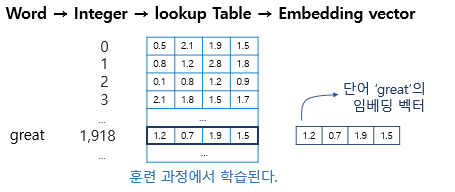



위의 그림은 단어 great이 정수 인코딩 된 후 테이블로부터 해당 인덱스에 위치한 임베딩 벡터를 꺼내오는 모습을 보여줍니다. 위의 그림에서는 임베딩 벡터의 차원이 4로 설정되어져 있습니다. 그리고 단어 great은 정수 인코딩 과정에서 1,918의 정수로 인코딩이 되었고 그에 따라 단어 집합의 크기만큼의 행을 가지는 테이블에서 인덱스 1,918번에 위치한 행을 단어 great의 임베딩 벡터로 사용합니다. 이 임베딩 벡터는 모델의 입력이 되고, 역전파 과정에서 단어 great의 임베딩 벡터값이 학습됩니다.

룩업 테이블의 개념을 이론적으로 우선 접하고, 처음 케라스를 배울 때 어떤 분들은 임베딩 층의 입력이 원-핫 벡터가 아니어도 동작한다는 점에 헷갈려 합니다. 케라스는 단어를 정수 인덱스로 바꾸고 원-핫 벡터로 한번 더 바꾸고나서 임베딩 층의 입력으로 사용하는 것이 아니라, 단어를 정수 인덱스로만 바꾼채로 임베딩 층의 입력으로 사용해도 룩업 테이블 된 결과인 임베딩 벡터를 리턴합니다.

케라스의 임베딩 층 구현 코드를 봅시다.

In [0]:
# 아래 인자는 영수증 데이터셋을 기반으로 판단한 숫자입니다.
# v = Embedding(50000, 128, input_length=120)
# vocab_size = 20000
# output_dim = 128
# input_length = 500

임베딩 층은 다음과 같은 세 개의 인자를 받습니다.

- vocab_size : 텍스트 데이터의 전체 단어 집합의 크기입니다.
- output_dim : 워드 임베딩 후의 임베딩 벡터의 차원입니다.
- input_length : 입력 시퀀스의 길이입니다. 만약 갖고있는 각 샘플의 길이가 500개의 단어로 구성되어있다면 이 값은 500이 됩니다.

Embedding()은 (number of samples, input_length)인 2D 정수 텐서를 입력받습니다. 이 때 각 sample은 정수 인코딩이 된 결과로, 정수의 시퀀스입니다. Embedding()은 워드 임베딩 작업을 수행하고 (number of samples, input_length, embedding word dimentionality)인 3D 실수 텐서를 리턴합니다. 케라스의 임베딩 층(embedding layer)을 사용하는 간단한 실습을 진행해보겠습니다.

## 2) 임베딩 층 사용하기

임베딩 층을 복습해보겠습니다. 영수증 데이터셋을 불러와서 작업해보겠습니다.

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 훈련파일, 테스트파일 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_file_link = '/content/drive/My Drive/text/dataset.txt'

In [5]:
# 불러온 데이터를 보면 id, document, label로 구분이 되어있습니다.
train_data = pd.read_csv(train_file_link, header = 0, delimiter = '\t', quoting = 3)
train_data.head(10)

,id,document,label
0,1,성북도 청주시 흥덕구 사운로 303,2
1,2,6098101574 구장고 TEL : 043- 260 - 15,3
2,3,2020- 02 - 29 20 : 17 : 29 POS : 1001 -00081 M...,4
3,4,고객센터 : 1577 - 4887 www .eliveyoung . co . KI,0
4,5,교환/ 환불은 결제일로부터 15일(3월 15일) 내,0
5,6,판매가능한 정상품( 미개봉) 에 한해 결제했던,0
6,7,수단과 구매영수증 지참 후 매장 방문시 가능,0
7,8,* 단 환불/ 결제수단 변경은 구매매장에서만,0
8,9,가능.,0
9,10,* 부분교환 영수증/선물교환중에 의한 환불은,0


In [6]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 208kB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 2.4MB 56.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


### 전처리작업(토크나이징)

In [0]:
import re
import json
from konlpy.tag import Okt

from tqdm import tqdm

In [0]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거. + 영어 소문자, 대문자, 숫자도 제외
    # 일단 OCR 결과의 원형을 학습시키기 위해 정규표현식을 사용하지 않고 학습시켜보겠습니다.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9\\s]", " ",  review)
    #review_text = re.sub(" ", "",  review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [9]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', 
              '주', '등', '한', '(', ')', '/', '*', '=', 'E', '|', '-', '.', ',', 'II', 'لالالالا', 
              '|||||||||', 'iii', '|||', '. ', '.', '"', ' )', '[', ']', '"']
okt = Okt()
clean_train_review = []

for review in tqdm(train_data['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

100%|██████████| 72000/72000 [00:53<00:00, 1352.52it/s]


In [0]:
sentences = clean_train_review
y_train = train_data['label']

문장과 레이블 데이터를 만들었습니다. 

In [11]:
t = Tokenizer()
t.fit_on_texts(sentences)
vocab_size = len(t.word_index) + 1

print(vocab_size)

20413


케라스의 Tokenizer()를 사용하여 토큰화를 시켰습니다.

In [12]:
X_encoded = t.texts_to_sequences(sentences)
print(X_encoded)

[[5010, 331, 1089, 2143, 816, 3216], [515, 206, 194, 65, 718, 1303, 126], [114, 117, 201, 142, 157, 201, 85, 137, 1927, 232, 341], [35, 93, 61, 87, 38, 5011, 68, 1610], [1, 4, 8, 82, 89, 59, 193, 59, 15], [37, 102, 111, 67, 90, 18, 77, 8, 19], [29, 78, 62, 7, 30, 14, 83, 11, 22, 5, 9], [95, 4, 8, 29, 72, 49, 47, 11, 97], [9], [28, 1, 7, 31, 1, 291, 18, 80, 4], [110, 28, 1, 7, 31, 1, 26, 54, 30, 14], [19, 11, 22, 5, 56, 10, 24, 6, 94], [1, 53, 9], [75, 74, 69, 14, 5, 1, 4, 12], [23, 25, 6, 1, 4, 12], [], [16, 109, 35, 86], [], [6, 42, 73, 63, 154, 151], [3, 719, 505, 1761, 386, 384, 1928, 765, 66, 55], [7576, 41, 13, 20, 113, 13], [20, 119, 58, 265, 243, 115], [279, 115, 3, 115], [6, 120, 71, 21, 44, 39, 40, 48, 21], [23, 25, 46, 52, 57, 43, 12], [76, 51, 101, 317], [44, 39, 40, 296], [1155, 350, 48, 51, 3217, 3905, 115], [37, 70, 113, 115], [86, 16, 113, 115], [8, 10, 113, 115], [33, 10, 113, 115], [16, 17, 669, 261], [16, 152, 337], [33, 17, 7577, 79, 104], [36, 58, 3218, 149], [167, 

각 문장에 대해서 정수 인코딩을 수행합니다.

In [13]:
max_len=max(len(l) for l in X_encoded)
print(max_len)

50


문장 중에서 가장 길이가 긴 문장의 길이는 45입니다.

In [14]:
X_train=pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train=np.array(y_train)
print(X_train)
print(y_train)

[[ 5010   331  1089 ...     0     0     0]
 [  515   206   194 ...     0     0     0]
 [  114   117   201 ...     0     0     0]
 ...
 [   36    58   535 ...     0     0     0]
 [  167   857  3678 ...     0     0     0]
 [20412     0     0 ...     0     0     0]]
[2 3 4 ... 1 2 2]


In [0]:
input_data = X_train
label_data = y_train
word_index = t.word_index

In [16]:
word_index

{'교환': 1,
 '포인트': 2,
 '1': 3,
 '환불': 4,
 '시': 5,
 '상품': 6,
 '영수증': 7,
 '결제': 8,
 '가능': 9,
 '금액': 10,
 '매장': 11,
 '불가': 12,
 '000': 13,
 '차다': 14,
 '내': 15,
 '카드': 16,
 '번호': 17,
 '에': 18,
 '하다': 19,
 '2': 20,
 '품목': 21,
 '방문': 22,
 '클리어': 23,
 '이상': 24,
 '런스': 25,
 '증': 26,
 '역': 27,
 '부분': 28,
 '수단': 29,
 '지다': 30,
 '선물': 31,
 '적립': 32,
 '승인': 33,
 '가용': 34,
 '고객': 35,
 'cj': 36,
 '판매': 37,
 'www': 38,
 '가다': 39,
 '세': 40,
 '3': 41,
 '명': 42,
 '할인': 43,
 '부': 44,
 '로': 45,
 '쿠폰': 46,
 '매': 47,
 '면세': 48,
 '구': 49,
 '900': 50,
 '합계': 51,
 '제휴': 52,
 '만': 53,
 '을': 54,
 '행사': 55,
 '해당': 56,
 '중복': 57,
 '올리브영': 58,
 '15일': 59,
 '500': 60,
 '1577': 61,
 '구매': 62,
 '수량': 63,
 'cjone': 64,
 'tel': 65,
 '매가': 66,
 '미개': 67,
 'co': 68,
 '미지': 69,
 '계': 70,
 '표시': 71,
 '변경': 72,
 '단가': 73,
 '품': 74,
 '증정': 75,
 '과세': 76,
 '한해': 77,
 '과': 78,
 '일': 79,
 '의하다': 80,
 'one': 81,
 '일로': 82,
 '후': 83,
 'kr': 84,
 'pos': 85,
 '용': 86,
 '4887': 87,
 'com': 88,
 '부터': 89,
 '봉': 90,
 '익일': 91,
 '사용': 92

### 훈련데이터 훈련,검증,테스트셋 나누기

In [0]:
TEST_SPLIT = 0.1
RNG_SEED = 951357
VOCAB_SIZE = len(word_index)+1
EMB_SIZE = 20
BATCH_SIZE = 256
NUM_EPOCHS = 15

인풋 데이터와 인풋 레이블을 앞서 설정한 변수값에 맞추어 훈련, 검증, 테스트 데이터로 나눠주도록 하겠습니다.

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

input_train, input_test, label_train, label_test = train_test_split(input_data, label_data, test_size=TEST_SPLIT, random_state=RNG_SEED)
#10%의 데이터를 테스트 데이터로 활용하도록 하겠습니다.

훈련(90%), 테스트(10%)를 나눴으니 훈련 데이터에서 일정량을 떼어 검증 데이터로 사용하겠습니다.

In [0]:
input_val = input_train[57600:]
label_val = label_train[57600:]
input_train = input_train[:57600]
label_train = label_train[:57600]

In [20]:
print(len(input_train),len(label_train),': 훈련용 데이터/라벨','\n',len(input_val),len(label_val),': 검증용 데이터/라벨','\n',len(input_test),len(label_test),': 테스트용 데이터/라벨')

57600 57600 : 훈련용 데이터/라벨 
 7200 7200 : 검증용 데이터/라벨 
 7200 7200 : 테스트용 데이터/라벨


### 패딩작업, 원핫인코딩

In [21]:
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

Using TensorFlow backend.


In [0]:
# 데이터셋 전처리 : 문장 길이 맞추기
input_train = sequence.pad_sequences(input_train, maxlen=max_len)
input_val = sequence.pad_sequences(input_val, maxlen=max_len)
input_test = sequence.pad_sequences(input_test, maxlen=max_len)

#ndarray with shape(30000,45) : input_train
#ndarray with shape(5432,45) : input_val
#ndarray with shape(3937,45) : input_test

In [0]:
# one-hot 인코딩
label_train = np_utils.to_categorical(label_train)
label_val = np_utils.to_categorical(label_val)
label_test = np_utils.to_categorical(label_test)

#ndarray with shape(30000, 20) : label_train
#ndarray with shape(5432, 20) : label_val
#ndarray with shape(3937, 20) : label_test

### 다중클래스분류(정밀도,재현율 측정/단어임베딩)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

from keras import backend as K

In [0]:
# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1) # y_true: 실제 값, 티아노 및 텐스플로우의 텐서(tensor)
        class_id_pred = K.argmax(y_pred, axis=-1) # y_pred: 예측 값, 티아노 및 텐스플로우의 텐서(tensor)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec

In [0]:
# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall

In [0]:
# 사전 훈련되지 않은 임베딩 사용하기
model = Sequential()
#model.add(Embedding(vocab_size, 128, input_length=max_len)) # 모든 임베딩 벡터는 4차원.
#model.add(Embedding(vocab_size, 1, input_length=max_len)) # 임베딩 출력층(output_dim)이 1이면 정확도, 정밀도, 재현율 모두 저하된다.
model.add(Embedding(vocab_size, 256, input_length=max_len)) # 배치사이즈가 기존(128)보다 2배 커지면 어떻게 될까? => 정밀도, 재현율, 정확도 모두 올라갔다.
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 256)           5225728   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 256)           196864    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)               

출력층에 20개의 뉴런에 활성화 함수로는 categorical_crossentropy 함수를 사용하여 다중 분류를 수행합니다.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy',
                       single_class_precision(0), single_class_recall(0),
                       single_class_precision(1), single_class_recall(1),
                       single_class_precision(2), single_class_recall(2),
                       single_class_precision(3), single_class_recall(3),
                       single_class_precision(4), single_class_recall(4),
                       single_class_precision(5), single_class_recall(5),
                       single_class_precision(6), single_class_recall(6),
                       single_class_precision(7), single_class_recall(7),
                       single_class_precision(8), single_class_recall(8),
                       single_class_precision(9), single_class_recall(9),
                       single_class_precision(10), single_class_recall(10),
                       single_class_precision(11), single_class_recall(11),
                       single_class_precision(12), single_class_recall(12),
                       single_class_precision(13), single_class_recall(13),
                       single_class_precision(14), single_class_recall(14)])

In [34]:
model.fit(input_train, label_train, batch_size=256, epochs=15, verbose=1, validation_data=(input_val, label_val)) # validation_data는 각 훈련마다 결과값을 도출할 측정 데이터를 의미한다. 따라서 가중치 업데이트는 되지 않는다.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 57600 samples, validate on 7200 samples
Epoch 1/15





57600/57600 [==============================] - 115s 2ms/step - loss: 0.5828 - acc: 0.8602 - prec: 0.8683 - recall: 0.9824 - prec_1: 0.6842 - recall_1: 0.6078 - prec_2: 0.5335 - recall_2: 0.4400 - prec_3: 0.6457 - recall_3: 0.6095 - prec_4: 0.6305 - recall_4: 0.5984 - prec_5: 0.6818 - recall_5: 0.6506 - prec_6: 0.7050 - recall_6: 0.7348 - prec_7: 0.6551 - recall_7: 0.6131 - prec_8: 0.6519 - recall_8: 0.6525 - prec_9: 0.6178 - recall_9: 0.5851 - prec_10: 0.6461 - recall_10: 0.6024 - prec_11: 0.6917 - recall_11: 0.6377 - prec_12: 0.0044 - recall_12: 7.4074e-04 - prec_13: 0.6807 - recall_13: 0.5926 - prec_14: 0.1067 - recall_14: 0.1044 - prec_15: 0.0000e+00 - recall_15: 0.0000e+00 - prec_16: 0.0000e+00 - recall_16: 0.0000e+00 - prec_17: 0.0000e+00 - recall_17: 0.0000e+00 - prec_18: 0.0000e+00 - recall_18: 0.0000e+00 - prec_19: 0.0

7200/7200 [==============================] - 2s 339us/step
## evaluation loss and_metrics ##
[0.25284261412090725, 0.9466666666666667, 0.9585792711046007, 0.9737981131341722, 0.8986027230156792, 0.9457628801133897, 0.8941221788194444, 0.9372460089789496, 0.9189863120185005, 0.9091468302408854, 0.8951877763536241, 0.9505865012274848, 0.9655715603298611, 0.9773851903279622, 0.9668376074896918, 0.877566040886773, 0.9425502946641711, 0.9911111111111112, 0.9471604919433594, 0.8896018303765191, 0.931545787387424, 0.8969445376925999, 0.9282203208075629, 0.9471225017971463, 0.8968888939751519, 0.9730370373196072, 0.3318518532647027, 0.07974425792694091, 0.8860268614027236, 0.8863809500800238, 0.64, 0.6518518532647027, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


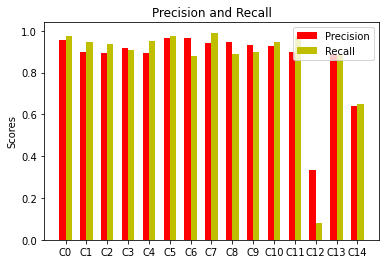

In [35]:
# 6. 모델 평가하기
loss_and_metrics = model.evaluate(input_test, label_test, batch_size=512)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

import numpy as np

metrics = np.array(loss_and_metrics[2:32])
idx = np.linspace(0, 29, num=30) 
precision = metrics[(idx % 2) == 0]
recall = metrics[((idx+1) % 2) == 0]

import matplotlib.pyplot as plt

N = 15
ind = np.arange(N)
width = 0.3

fig, ax = plt.subplots()
prec_bar = ax.bar(ind, precision, width, color='r')
recall_bar = ax.bar(ind + width, recall, width, color='y')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'))

ax.legend((prec_bar[0], recall_bar[0]), ('Precision', 'Recall'))

plt.show()

In [36]:
print("loss : ", loss_and_metrics[0])
print("acc : ", loss_and_metrics[1],'\n')
print("불필요정보 정밀도 : ", loss_and_metrics[2])
print("불필요정보 재현율 : ", loss_and_metrics[3],'\n')
print("브랜드, 지점명 정밀도 : ", loss_and_metrics[4])
print("브랜드, 지점명 재현율 : ", loss_and_metrics[5],'\n')
print("주소 정밀도 : ", loss_and_metrics[6])
print("주소 재현율 : ", loss_and_metrics[7],'\n')
print("사업자등록번호, 대표자명, 전화번호 정밀도 : ", loss_and_metrics[8])
print("사업자등록번호, 대표자명, 전화번호 재현율 : ", loss_and_metrics[9],'\n')
print("구매일시 정밀도 : ", loss_and_metrics[10])
print("구매일시 재현율 : ", loss_and_metrics[11],'\n')
print("상품명 정밀도 : ", loss_and_metrics[12])
print("상품명 재현율 : ", loss_and_metrics[13],'\n')
print("상품바코드, 단가, 수량, 금액 정밀도 : ", loss_and_metrics[14])
print("상품바코드, 단가, 수량, 금액 재현율 : ", loss_and_metrics[15],'\n')
print("결제금액 정밀도 : ", loss_and_metrics[16])
print("결제금액 재현율 : ", loss_and_metrics[17],'\n')
print("카드금액 정밀도 : ", loss_and_metrics[18])
print("카드금액 재현율 : ", loss_and_metrics[19],'\n')
print("카드번호 정밀도 : ", loss_and_metrics[20])
print("카드번호 재현율 : ", loss_and_metrics[21],'\n')
print("카드사명 정밀도 : ", loss_and_metrics[22])
print("카드사명 재현율 : ", loss_and_metrics[23],'\n')
print("카드승인번호 정밀도 : ", loss_and_metrics[24])
print("카드승인번호 재현율 : ", loss_and_metrics[25],'\n')
print("영수증 바코드 정밀도 : ", loss_and_metrics[26])
print("영수증 바코드 재현율 : ", loss_and_metrics[27],'\n')
print("결제방법 정밀도 : ", loss_and_metrics[28])
print("결제방법 재현율 : ", loss_and_metrics[29],'\n')
print("현금영수증 승인번호 정밀도 : ", loss_and_metrics[30])
print("현금영수증 승인번호 재현율 : ", loss_and_metrics[31],'\n')

loss :  0.25284261412090725
acc :  0.9466666666666667 

불필요정보 정밀도 :  0.9585792711046007
불필요정보 재현율 :  0.9737981131341722 

브랜드, 지점명 정밀도 :  0.8986027230156792
브랜드, 지점명 재현율 :  0.9457628801133897 

주소 정밀도 :  0.8941221788194444
주소 재현율 :  0.9372460089789496 

사업자등록번호, 대표자명, 전화번호 정밀도 :  0.9189863120185005
사업자등록번호, 대표자명, 전화번호 재현율 :  0.9091468302408854 

구매일시 정밀도 :  0.8951877763536241
구매일시 재현율 :  0.9505865012274848 

상품명 정밀도 :  0.9655715603298611
상품명 재현율 :  0.9773851903279622 

상품바코드, 단가, 수량, 금액 정밀도 :  0.9668376074896918
상품바코드, 단가, 수량, 금액 재현율 :  0.877566040886773 

결제금액 정밀도 :  0.9425502946641711
결제금액 재현율 :  0.9911111111111112 

카드금액 정밀도 :  0.9471604919433594
카드금액 재현율 :  0.8896018303765191 

카드번호 정밀도 :  0.931545787387424
카드번호 재현율 :  0.8969445376925999 

카드사명 정밀도 :  0.9282203208075629
카드사명 재현율 :  0.9471225017971463 

카드승인번호 정밀도 :  0.8968888939751519
카드승인번호 재현율 :  0.9730370373196072 

영수증 바코드 정밀도 :  0.3318518532647027
영수증 바코드 재현율 :  0.07974425792694091 

결제방법 정밀도 :  0.8860268614027236
결제방법 재현율 :  

테스트 데이터에 대한 정확도가 아니며 훈련 데이터도 양이 적어서 정확도에 의미는 없지만, 여기서 말하고자 하는 점은 현재 각 단어들의 임베딩 벡터들의 값은 학습 과정에서 다른 가중치들과 함께 학습된 값입니다.

+ 테스트 시 배치 사이즈를 512까지 늘렸더니 재현율과 정밀도가 평균적으로 90% 넘습니다. 제 생각엔 믿을 수 없는 결과입니다. 
일반적으로 배치사이즈가 1이면 문제가 100개일 때 한문제를 풀고 답을 맞추고, 가중치를 갱신하고 다음 문제를 풀겠다는 의미입니다. 따라서 
배치사이즈가 작을수록 가중치 갱신이 자주 일어납니다.
03.17 model.fit()의 배치사이즈부터 1, 128, 512 순으로 조정하여 실험해보겠습니다.

## 예측 결과 확인하고 저장하기

In [0]:
model.predict_classes(input_data)

array([ 2, 16, 16, ..., 12,  0, 12])

In [0]:
train_data['label'] = model.predict_classes(input_data)

In [38]:
!pip install xlsxwriter

     |████████████████████████████████| 143kB 2.8MB/s 


In [0]:
dataframe = pd.DataFrame(train_data)
dataframe.to_excel("/content/drive/My Drive/text/keras_embedding(14labels).xlsx", engine='xlsxwriter', index=False)

### 모델 저장하고 불러오기

In [0]:
# 라이브러리 임포트
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
import pandas as pd

In [0]:
# 모델을 json형식으로 만들어서 저장
model_json = model.to_json()
with open("/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/OCR result text Classification/model/14label_Embedding_model.json", "w") as json_file : 
    json_file.write(model_json)

In [42]:
# 가중치를 h5 포맷으로 만들어서 저장
model.save_weights("/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/OCR result text Classification/model/14label_Embedding_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# 저장된 json파일로부터 모델 불러오기
from keras.models import model_from_json 
json_file = open("/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/OCR result text Classification/model/self_Embedding_model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)

In [0]:
# 로드한 모델에 가중치 로드하기
loaded_model.load_weights("/content/drive/My Drive/캐시카우_노하람인턴_공유폴더/OCR result text Classification/model/self_Embedding_model.h5") 
print("Loaded model from disk")

Loaded model from disk


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 256)           3149056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 43, 256)           196864    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)               

## 테스트 데이터로 예측치 확인하기

In [0]:
test_file_link = '/content/drive/My Drive/datt/테스트용텍스트.txt'

In [0]:
test_file_link = '/content/drive/My Drive/datt/CNN_텍스트분류_정답_수정.txt'

In [44]:
test_data = pd.read_csv(test_file_link, header = 0, delimiter = '\t', quoting = 3)
test_data.head(10)

,id,document,label
0,1,1** 올리브영,NaN
1,2,스마트영수증 매장쿠폰,NaN
2,3,매장전화 고객센터 사이트연결,NaN
3,4,CJ올리브영㈜동탄한빛점,NaN
4,5,경기도 화성시 동탄중심상가2길37,NaN
5,6,8098101574 TEL :031-613 -7457,NaN
6,7,2020-03-19 12:40:20 POS:1001- 00026 K .명주,NaN
7,8,고객센터 : 1577-4887 www.oliveyoung.co.kr,NaN
8,9,교환/환불은 결제일로부터 15일(4월 3일) 내,NaN
9,10,판매가능한 정상품(미개봉) 에 한해 결제했던,NaN


In [0]:
label_tmp = np.array(test_data['label'])
label_tmp = np_utils.to_categorical(label_tmp)

In [0]:
label_tmp

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
test_data.head(10)

,id,document,label
0,1,1** 올리브영,NaN
1,2,스마트영수증 매장쿠폰,NaN
2,3,매장전화 고객센터 사이트연결,NaN
3,4,CJ올리브영㈜동탄한빛점,NaN
4,5,경기도 화성시 동탄중심상가2길37,NaN
5,6,8098101574 TEL :031-613 -7457,NaN
6,7,2020-03-19 12:40:20 POS:1001- 00026 K .명주,NaN
7,8,고객센터 : 1577-4887 www.oliveyoung.co.kr,NaN
8,9,교환/환불은 결제일로부터 15일(4월 3일) 내,NaN
9,10,판매가능한 정상품(미개봉) 에 한해 결제했던,NaN


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

t = Tokenizer()

In [0]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거. + 영어 소문자, 대문자, 숫자도 제외
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9\\s]", " ",  review)
    #review_text = " ".join(review_text.split()) # 공백이 두칸일 경우 한 칸 제거
    #review_text = re.sub(" ", "",  review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [48]:
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', 
              '주', '등', '한', '(', ')', '/', '*', '=', 'E', '|', '-', '.', ',', 'II', 'لالالالا', 
              '|||||||||', 'iii', '|||', '. ', '.', '"', ' )', '[', ']', '"']
okt = Okt()
clean_test_review = []

for review in tqdm(test_data['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

100%|██████████| 5000/5000 [00:04<00:00, 1165.34it/s]


In [49]:
clean_test_review[0:10]

[['1', '올리브영'],
 ['스마트', '영수증', '매장', '쿠폰'],
 ['매장', '전화', '고객', '센터', '사이트', '연결'],
 ['CJ', '올리브영', '동탄', '한빛', '점'],
 ['경기도', '화성시', '동탄', '중심', '상가', '2', '길', '37'],
 ['8098101574', 'TEL', '031', '613', '7457'],
 ['2020', '03', '19', '12', '40', '20', 'POS', '1001', '00026', 'K', '명주'],
 ['고객', '센터', '1577', '4887', 'www', 'oliveyoung', 'co', 'kr'],
 ['교환', '환불', '결제', '일로', '부터', '15일', '4월', '3일', '내'],
 ['판매', '가능하다', '정상품', '미개', '봉', '에', '한해', '결제', '하다']]

In [0]:
sentences2 = clean_test_review

In [0]:
t = Tokenizer()
#t.fit_on_texts(sentences) #이게 문제다. 이미 21300문자의 빈도수별로 인덱스를 정해놓은 것을 사용해야하는데, 새로운 데이터로 fit_on_texts를 하면 새로운 데이터에 맞게 인덱스가 바뀌어버린다.
t.fit_on_texts(sentences2)

In [54]:
sentences2[1]

['스마트', '영수증', '매장', '쿠폰']

In [55]:
#test_encoded = t.texts_to_sequences(sentences2)
test_encoded = t.texts_to_sequences(sentences2)
#test_encoded = t.texts_to_matrix(sentences2)
print(test_encoded)


[[3, 75], [171, 8, 11, 40], [11, 331, 26, 93, 377, 378], [36, 75, 704, 1141, 139], [187, 1142, 704, 1143, 530, 19, 431, 300], [127, 59, 195, 531, 1144], [76, 57, 144, 128, 213, 132, 106, 133, 705, 193, 1145], [26, 93, 63, 89, 37, 118, 72, 82], [1, 4, 10, 90, 108, 68, 110, 270, 16], [38, 114, 116, 77, 86, 18, 91, 10, 20], [28, 98, 61, 8, 34, 15, 99, 11, 23, 5, 9], [83, 4, 10, 28, 70, 48, 49, 11, 100, 706], [9], [29, 1, 8, 31, 1, 30, 18, 84, 4], [109, 29, 1, 8, 31, 1, 30, 78, 34, 15], [20, 11, 23, 5, 58, 7, 24, 6, 101], [1, 55, 9], [85, 73, 66, 15, 1, 4, 13], [22, 25, 6, 1, 4, 13], [], [14, 97, 26, 79], [], [6, 41, 69, 64, 7], [164], [3, 197, 198, 332, 301, 302, 249, 159], [707, 3, 12, 3, 3, 12], [6, 125, 67, 21, 123, 53, 21], [22, 25, 40, 56, 62, 39, 13], [112, 65, 250], [123, 1146], [38, 71, 3, 12], [111, 3, 12], [10, 7, 3, 12], [32, 7, 3, 708, 251, 1147], [14, 17, 1148, 144], [14, 134, 252, 14], [32, 17, 1149, 80, 94], [181, 303, 119, 36, 87, 2, 16, 27], [117, 17, 1150], [35, 2, 132],

In [56]:
y_train = test_data['label']
y_train=np.array(y_train)
y_train[:] = 0
print(len(y_train), y_train)

5000 [0. 0. 0. ... 0. 0. 0.]


In [57]:
test=pad_sequences(test_encoded, maxlen=50, padding='post')

#test=pad_sequences(t.texts_to_sequences(test_encoded), maxlen=max_len, padding='post')
print(test)
# 테스트 데이터의 패딩작업(훈련을 45개의 단어길이로 했으니 테스트 데이터를 예측할 때도 45개의 문장길리로 맞추어주어야한다.)

[[  3  75   0 ...   0   0   0]
 [171   8  11 ...   0   0   0]
 [ 11 331  26 ...   0   0   0]
 ...
 [ 22  25   6 ...   0   0   0]
 [173 189   8 ...   0   0   0]
 [ 14  97  26 ...   0   0   0]]


In [58]:
len(word_index)

20412

In [0]:
#model.predict_classes(test)
model.predict_classes(test)
#model.predict_classes(input_test)

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
test_data['label'] = model.predict_classes(test)

In [60]:
test_data.head(10)

,id,document,label
0,1,1** 올리브영,0
1,2,스마트영수증 매장쿠폰,0
2,3,매장전화 고객센터 사이트연결,0
3,4,CJ올리브영㈜동탄한빛점,1
4,5,경기도 화성시 동탄중심상가2길37,5
5,6,8098101574 TEL :031-613 -7457,0
6,7,2020-03-19 12:40:20 POS:1001- 00026 K .명주,0
7,8,고객센터 : 1577-4887 www.oliveyoung.co.kr,0
8,9,교환/환불은 결제일로부터 15일(4월 3일) 내,0
9,10,판매가능한 정상품(미개봉) 에 한해 결제했던,0


In [0]:
dataframe = pd.DataFrame(test_data)
dataframe.to_excel("/content/drive/My Drive/text/14label_result.xlsx", engine='xlsxwriter', index=False)

# 임시코드

In [0]:
def clean_text(review):
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  
    review = re.sub(pattern=pattern, repl='', string=review)
    #print("한글 자음 모음 제거 : ", review , "\n")
    pattern = '<[^>]*>'        
    review = re.sub(pattern=pattern, repl='', string=review)
    #print("태그 제거 : " , review , "\n")
    pattern = r'\([^)]*\)'
    review = re.sub(pattern=pattern, repl='', string=review)
    #print("괄호와 괄호안 글자 제거 :  " , review , "\n")
    pattern = '[^\w\s]'   
    review = re.sub(pattern=pattern, repl='', string=review)
    #print("특수기호 제거 : ", review , "\n" )
    review = review.strip()
    #print("양 끝 공백 제거 : ", review , "\n" )
    review = " ".join(review.split())
    #print("중간에 공백은 1개만 : ", review )
    return review   

def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거. + 영어 소문자, 대문자, 숫자도 제외
    review_text = clean_text(review)
    #review_text = " ".join(review_text.split()) # 공백이 두칸일 경우 한 칸 제거
    #review_text = re.sub(" ", "",  review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [0]:
vocab_size = len(t.word_index) + 1

print(vocab_size)
word_index = t.word_index

13493
